In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas
from astropy import units as u
from astropy.coordinates import (SkyCoord, Distance, Galactic, 
                                 EarthLocation, AltAz)
from read_mist_models import ISOCMD
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
import scipy
import scipy as stats
from astroquery.gaia import Gaia
import glob


#copy and paste code cite vespa anyways

In [1]:
path =  r'C:\Users\astro\SSG_Spectra\Metallicities\\'
file = path + 'ssg_table1.txt'
gaia_ids = np.genfromtxt(file, usecols= 0, dtype = str)
gaia_ids2 = list(np.genfromtxt(file, usecols= 0, dtype = np.int64))
gaia_ids = str(list(gaia_ids)).strip('[]')
#classif = np.genfromtxt(file, usecols= 18, dtype = str)

#print(gaia_ids)


#print(df.columns.tolist())

In [2]:
#Do Not Mess with Query

query_text = f'''SELECT TOP 2000 subquery.source_id, ra, dec, bp_rp, phot_g_mean_mag, 
mh_gspphot, parallax, pmra, pmdec, galex.*
FROM (
  SELECT gaia.*, EPOCH_PROP_POS(ra, dec, parallax, pmra, pmdec, radial_velocity, ref_epoch, 2000) AS propagated_position_vector
  FROM gaiadr3.gaia_source AS gaia
  WHERE gaia.source_id IN ({gaia_ids})
  OFFSET 0) AS subquery
JOIN external.galex_ais AS galex
ON DISTANCE(COORD1(subquery.propagated_position_vector), 
COORD2(subquery.propagated_position_vector), galex.raj2000, galex.dej2000) < 3./3600.

'''



#f'''SELECT TOP 10000 *
#FROM gaiadr3.gaia_source 
#WHERE gaiadr3.gaia_source.source_id IN ({gaia_ids})'''

job = Gaia.launch_job(query_text) 
gaia_data = job.get_results()


In [3]:
print(job)

<Table length=1025>
      name       dtype    unit                                                    description                                                   n_bad
--------------- ------- -------- -------------------------------------------------------------------------------------------------------------- -----
      source_id   int64                                                      Unique source identifier (unique within a particular Data Release)     0
             ra float64      deg                                                                                                Right ascension     0
            dec float64      deg                                                                                                    Declination     0
          bp_rp float32      mag                                                                                                 BP - RP colour     0
phot_g_mean_mag float32      mag                                                

In [4]:
gaia_data['source_id', 'bp_rp'] #Create tables 

source_id,bp_rp
,mag
int64,float32
18910470421959808,1.7245846
34148700855166720,1.4843063
54254958891842816,1.2839956
71640436752289408,1.4130659
81709523719057536,1.2449026
98294935069481344,1.213253
99014050033715456,1.2758799
104747552200480256,1.3378077


In [5]:
#ra = gaia_data['ra']
#dec = gaia_data['dec']


c = SkyCoord(ra=gaia_data['ra'], dec=gaia_data['dec'], frame='icrs')
ra = c.ra.wrap_at(180 * u.deg).radian
dec = c.dec.radian
metallicity = np.array(gaia_data['mh_gspphot'], dtype = float)

dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
m_G = np.array(gaia_data['phot_g_mean_mag'], dtype = float)
uncorr_bp_rp = np.array(gaia_data['bp_rp'], dtype = float)
distance = np.array(dist, dtype = float)

uncor_nuv = np.array(gaia_data['nuvmag'], dtype =float)
uncor_fuv = np.array(gaia_data['fuvmag'], dtype = float)
E_BV = np.array(gaia_data['e_b_v'], dtype = float)

uncorr_fuv_nuv = uncor_fuv - uncor_nuv


In [6]:
av_tot = np.genfromtxt(file, usecols=16, dtype=float)
av = np.array([av_tot[gaia_ids2.index(item)] for item in gaia_data['source_id']], 
              dtype = float)


ag_gaia = av*0.789
Ebp_rp = ag_gaia/1.890 #ag/e(bp=rp) = 1.890
E_FUV_NUV = -2.35*E_BV #cite https://academic.oup.com/mnras/article/430/3/2188/981583#26020373
#E(a − b) = R(a − b) × E(B − V),
fuv_nuv = uncorr_fuv_nuv + E_FUV_NUV
bp_rp = uncorr_bp_rp + Ebp_rp
M_G = -5*np.log10(distance) + m_G - ag_gaia + 5 #m-M = 5log(d) - 5 + Av

In [7]:
ssg_file = r'photometric_datav1.csv'

df = pandas.read_csv(ssg_file, delimiter = ',')

print(df.columns.tolist())
ssg_ids = np.array(df['Gaia DR3 ID'], dtype=np.int64)
raw_ssg_name = np.array(df['star'], dtype = str)
raw_ssg_class = np.array(df['H-alpha Profile'], dtype=str)

['star', 'Gaia DR3 ID', '2MASS ID', 'GALEX ID', 'ra', 'dec', 'distance', 'vsini', 'VSX Period', 'Av', 'fe_h', 'm_G', 'Gaia G flux_over_error', 'm_BP', 'Gaia BP flux_over_error', 'm_RP', 'Gaia RP flux_over_error', '2MASS J', '2MASS J error', '2MASS H', '2MASS H error', '2MASS K', '2MASS K error', 'WISE W1', 'WISE W1 error', 'WISE W2', 'WISE W2 error', 'WISE W3', 'WISE W3 error', 'WISE W4', 'WISE W4 error', 'GALEX FUV', 'GALEX FUV Error', 'GALEX NUV', 'GALEX NUV Error', 'H-alpha Profile']


In [8]:
ssg_follow = [any(k == ssg_ids) for k in gaia_data['source_id']]
ssg_sample = gaia_data[ssg_follow]
ssg_list = list(ssg_ids)
ssg_name = np.array([raw_ssg_name[ssg_list.index(item)] if item 
        in ssg_sample['source_id'] else None for item in gaia_data['source_id']])
ssg_profile = np.array([raw_ssg_class[ssg_list.index(item)] if item 
        in ssg_sample['source_id'] else None for item in gaia_data['source_id']], dtype = str)

variable_ha = (ssg_profile == 'Variable H-alpha')
absorption = (ssg_profile == 'Absorption')
emission = (ssg_profile == 'Emission')

In [9]:
periods_tot = np.genfromtxt(file, usecols=12, dtype=float)
periods = np.array([periods_tot[gaia_ids2.index(item)] for item in gaia_data['source_id']], 
              dtype = float)

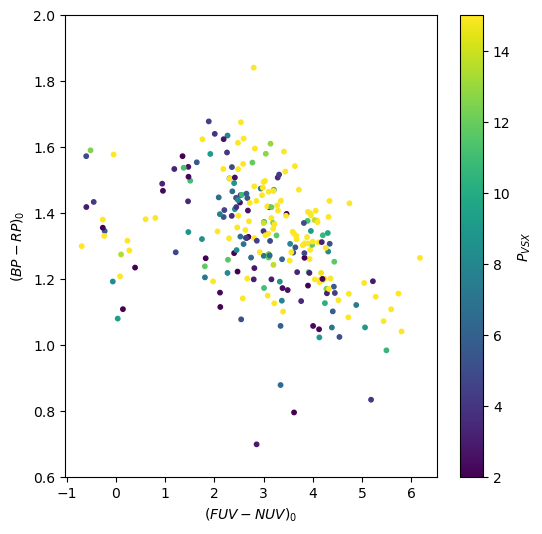

In [10]:
fig, ax = plt.subplots(1, figsize = (6,6))
cs = ax.scatter(fuv_nuv, bp_rp, s = 10, c = periods, vmin = 2, vmax=15)


cb = fig.colorbar(cs)
ax.set_xlabel('$(FUV-NUV)_0$')
ax.set_ylabel('$(BP-RP)_0$')
ax.set_ylim(0.60, 2.0)
cb.set_label('$P_{VSX}$')
#ax.legend()
#fig.savefig('SED_images\\uv_col.png', dpi = 300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


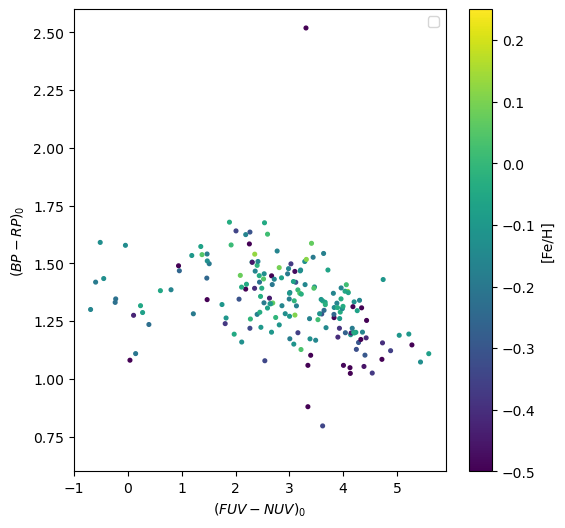

In [11]:
fig, ax = plt.subplots(1, figsize = (6,6))
cs = ax.scatter(fuv_nuv, bp_rp, s = 7, c = metallicity, vmin=-0.50, vmax=0.25)


cb = fig.colorbar(cs)
ax.set_xlabel('$(FUV-NUV)_0$')
ax.set_ylabel('$(BP-RP)_0$')
ax.set_ylim(0.60, 2.60)
cb.set_label('[Fe/H]')
ax.legend()

In [12]:
HUVir = (gaia_data['source_id'] == 326753999413912192)

label_list = [1655646778064790528, 3582095053777917952, 1489388868914750976,
              1494123125466322560, 1605979810614504704,  4437071962647534976]

excess2 = np.array([True if item in label_list else False for item in gaia_data['source_id']])

In [13]:
print(any(gaia_data['source_id'] == label_list[5]))

True


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


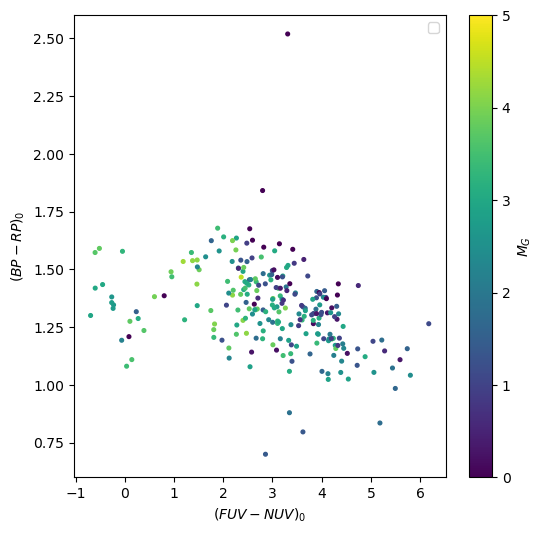

In [14]:
fig, ax = plt.subplots(1, figsize = (6,6))
cs = ax.scatter(fuv_nuv, bp_rp, s = 7, c = M_G,vmin=0, vmax=5)


cb = fig.colorbar(cs)
ax.set_xlabel('$(FUV-NUV)_0$')
ax.set_ylabel('$(BP-RP)_0$')
ax.set_ylim(0.60, 2.60)
cb.set_label('$M_G$')
ax.legend()

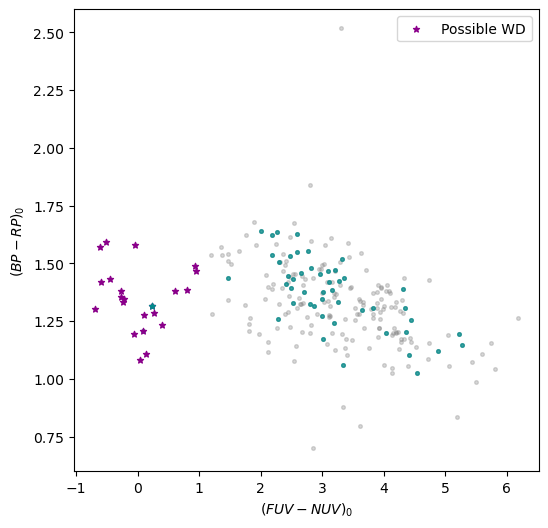

In [15]:
raw_labels = ['29 Dra','HU Vir', 'MX Boo', 'KY Boo', 'MP Boo', 'ASAS J162510+0514.9']

Dra29 = (gaia_data['source_id'] == 1655646778064790528)


excess2 = np.array([True if item in label_list else False for item in gaia_data['source_id']])
labels = np.array([raw_labels[list(label_list).index(item)] for item in gaia_data['source_id'][excess2]])

excess = (fuv_nuv <= 1.0)




fig, ax = plt.subplots(1, figsize = (6,6))
ax.scatter(fuv_nuv, bp_rp, s = 7, alpha = 0.3, color = 'gray')

ax.scatter(fuv_nuv[ssg_follow], bp_rp[ssg_follow], 
           s = 7, alpha = 0.7, color = 'darkcyan')

ax.scatter(fuv_nuv[excess], bp_rp[excess], marker = '*', 
           s = 20, alpha = 1, color = 'darkmagenta', label = 'Possible WD')

ax.scatter(fuv_nuv[Dra29], bp_rp[Dra29], marker = '*', s = 20, alpha = 1, color = 'darkcyan')


#for i in range(len(labels)): ax.text(fuv_nuv[excess2][i], bp_rp[excess2][i], labels[i])

ax.set_xlabel('$(FUV-NUV)_0$')
ax.set_ylabel('$(BP-RP)_0$')
ax.set_ylim(0.60, 2.60)
cb.set_label('$P_{VHX}$')
ax.legend()

-0.08897915165260531 1.6142192862796143


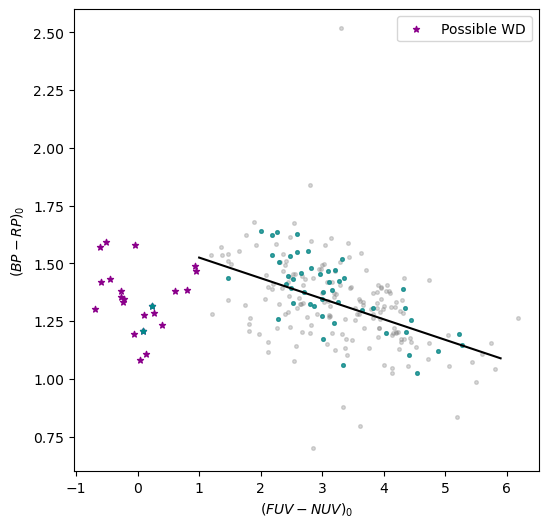

In [16]:
uv_relsamp = ((excess == False) & (np.isnan(fuv_nuv) == False) & (bp_rp < 1.75))


lingress = scipy.stats.linregress(fuv_nuv[uv_relsamp], bp_rp[uv_relsamp])
A, B, r, pval, sterr  = lingress

rel_uv = np.arange(1,6, 0.1)
print(A,B)
fig, ax = plt.subplots(1, figsize = (6,6))
ax.scatter(fuv_nuv[excess == False], bp_rp[excess == False], s = 7, alpha = 0.3, color = 'gray')


ax.scatter(fuv_nuv[ssg_follow], bp_rp[ssg_follow], 
           s = 7, alpha = 0.7, color = 'darkcyan')


ax.plot(rel_uv, A*rel_uv + B, color = 'black')

ax.scatter(fuv_nuv[excess], bp_rp[excess], marker = '*', 
           s = 20, alpha = 1, color = 'darkmagenta', label = 'Possible WD')

ax.scatter(fuv_nuv[excess & ssg_follow], bp_rp[ssg_follow & excess], marker = '*', 
           s = 20, alpha = 1, color = 'darkcyan')

ax.set_xlabel('$(FUV-NUV)_0$')
ax.set_ylabel('$(BP-RP)_0$')
ax.set_ylim(0.60, 2.60)
ax.legend()


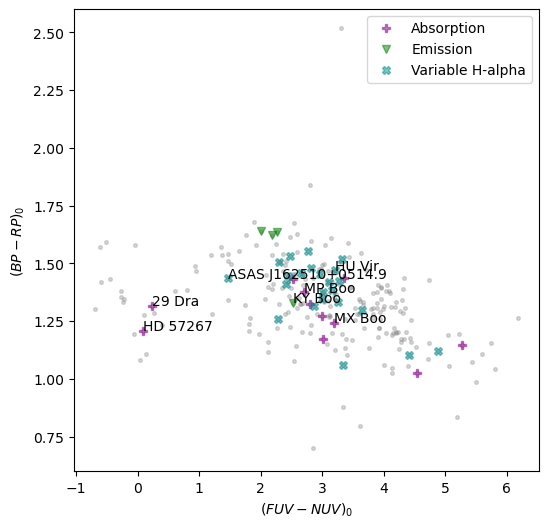

In [18]:
abs_color = 'darkmagenta'
emis_color = 'green'
var_color = 'darkcyan'

HD57267 = (gaia_data['source_id'] == 871136882231721600)

fig, ax = plt.subplots(1, figsize = (6,6))
ax.scatter(fuv_nuv, bp_rp, s = 7, alpha = 0.3, color = 'gray')
ax.plot(fuv_nuv[absorption], bp_rp[absorption], marker='P', linestyle='none', 
        alpha=0.5, color = abs_color, label = 'Absorption')
ax.plot(fuv_nuv[emission], bp_rp[emission], marker='v', linestyle='none', 
        alpha=0.5, color = emis_color, label = 'Emission')
ax.plot(fuv_nuv[variable_ha], bp_rp[variable_ha], marker='X', linestyle='none', 
        alpha=0.5, color = var_color, label = 'Variable H-alpha')
for i in range(len(labels)):
    ax.text(fuv_nuv[excess2][i], bp_rp[excess2][i], labels[i])
    
ax.text(fuv_nuv[HD57267], bp_rp[HD57267], 'HD 57267')
ax.set_xlabel('$(FUV-NUV)_0$')
ax.set_ylabel('$(BP-RP)_0$')
ax.set_ylim(0.60, 2.60)
ax.legend()

In [19]:
print(ssg_name[excess])
print(gaia_data['source_id'][excess])

[None None None 'HD 57267' None None None None None None None '29 Dra'
 None None None None None None None None None None]
     source_id     
-------------------
 397690027169628672
 654503129867566080
 755517221614519808
 871136882231721600
 906058127442277248
1232279031219489792
1303115931129472896
1381075634865165568
1382759605642657920
1422377586571452032
1642379516712248064
1655646778064790528
1708005315621055872
1954946040857509504
2129183449487791104
2660751378246429312
2791414904845325696
3178786251609990656
4246336931792668928
4554179743529140992
4884511622495522688
5567562330531287808


In [20]:
iso_file00 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bd9dbb9411.iso.cmd"
iso_file_low025 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdd54012f6.iso.cmd"
iso_file05 = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdbe235892.iso.cmd"
iso_file_HUVir = r"C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_67a40a1eec2f1.iso.cmd"
iso_00 = ISOCMD(iso_file00)
iso_low025 = ISOCMD(iso_file_low025)
iso_05 = ISOCMD(iso_file05)
iso_HUVir = ISOCMD(iso_file_HUVir)

Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bd9dbb9411.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdd54012f6.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_671bdbe235892.iso.cmd
Reading in: C:\Users\astro\SSG_Spectra\Metallicities\MIST_iso_67a40a1eec2f1.iso.cmd


In [21]:
#age_ind = isocmd.age_index(9.6) #returns the index for the desired age
G_00 = iso_00.isocmds[0]['Gaia_G_EDR3']
BP_RP00 = iso_00.isocmds[0]['Gaia_BP_EDR3'] - iso_00.isocmds[0]['Gaia_RP_EDR3']

G_05 = iso_05.isocmds[0]['Gaia_G_EDR3']
BP_RP05 = iso_05.isocmds[0]['Gaia_BP_EDR3'] - iso_05.isocmds[0]['Gaia_RP_EDR3']

G_low025 = iso_low025.isocmds[0]['Gaia_G_EDR3']
BP_RP_low025 = iso_low025.isocmds[0]['Gaia_BP_EDR3'] - iso_low025.isocmds[0]['Gaia_RP_EDR3']

In [22]:
fe_h1b = (metallicity > 0.0)
fe_h2b = (metallicity <= 0.0) & (metallicity > -0.25)
fe_h3b = (metallicity <= -0.25) & (metallicity >= -100)

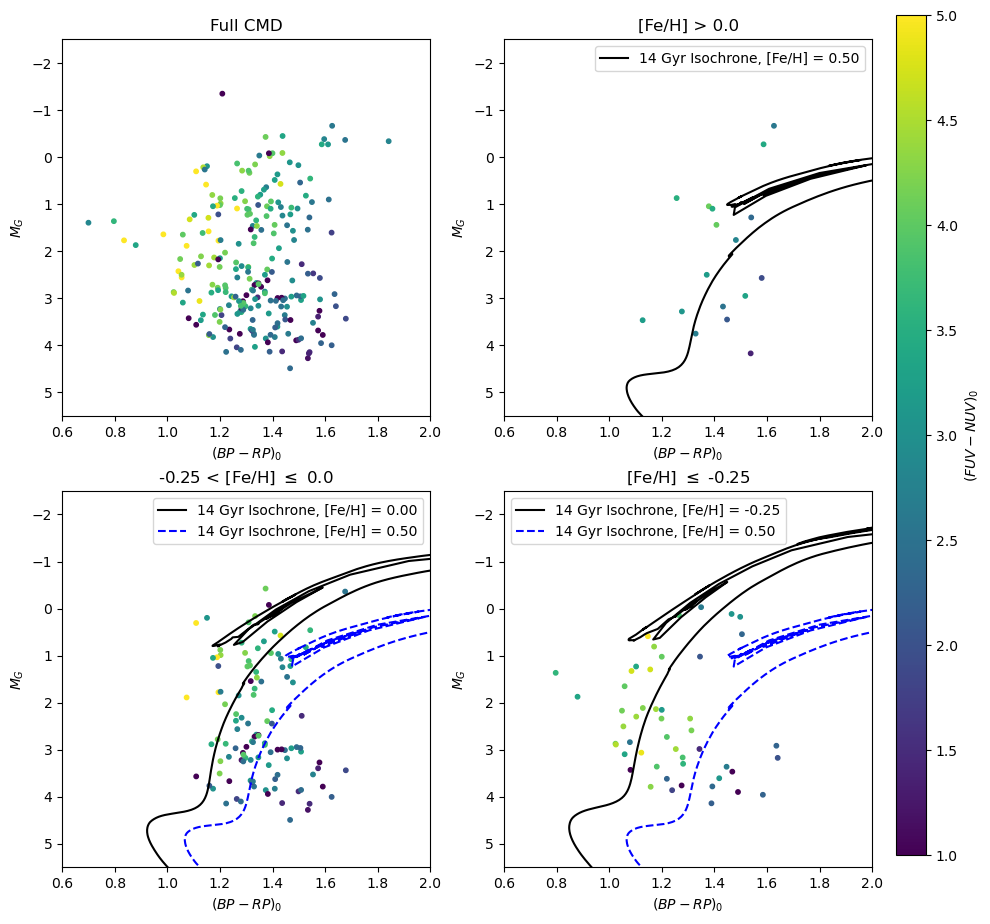

In [23]:
fig, axes = plt.subplots(2,2, figsize = (12,12))
[ax,ax2], [ax3,ax4] = axes
ax.set_title('Full CMD')
ax.scatter(bp_rp, M_G, s = 10, c = fuv_nuv, vmin = 1, vmax = 5)

ax.set_xlim(0.60, 2)
ax.set_ylim(-2.5,5.5)
ax.invert_yaxis()
ax.set_xlabel('$(BP-RP)_0$')
ax.set_ylabel('$M_G$')

#Subsample 1
ax2.plot(BP_RP05, G_05, color = 'black', label='14 Gyr Isochrone, [Fe/H] = 0.50')
ax2.set_title(r'[Fe/H] > 0.0')
ax2.scatter(bp_rp[fe_h1b], M_G[fe_h1b], s = 10, c = fuv_nuv[fe_h1b], vmin = 1, vmax = 5)
#ax[0,1].plot(iso['logTeff'], iso['logL'], label=f'Age: 14 Gyr, [Fe/H]: 0.50')
ax2.set_xlim(0.60, 2.00)
ax2.set_ylim(-2.5,5.5)
ax2.invert_yaxis()
ax2.set_xlabel('$(BP-RP)_0$')
ax2.set_ylabel('$M_G$')
ax2.legend()
#Subsample 2
ax3.set_title(r'-0.25 < [Fe/H] $\leq$ 0.0')
ax3.plot(BP_RP00, G_00, color = 'black', label= '14 Gyr Isochrone, [Fe/H] = 0.00')
ax3.plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label= '14 Gyr Isochrone, [Fe/H] = 0.50')
ax3.scatter(bp_rp[fe_h2b], M_G[fe_h2b], s = 10, c = fuv_nuv[fe_h2b], vmin = 1, vmax = 5)
ax3.set_xlim(0.60, 2.00)
ax3.set_ylim(-2.5,5.5)
ax3.invert_yaxis()
ax3.set_xlabel('$(BP-RP)_0$')
ax3.set_ylabel('$M_G$')

ax3.legend()
#Subsample 3
ax4.set_title(r'[Fe/H] $\leq$ -0.25')
ax4.plot(BP_RP_low025, G_low025, color = 'black', label= '14 Gyr Isochrone, [Fe/H] = -0.25')
ax4.plot(BP_RP05, G_05, color = 'blue', linestyle = '--', label= '14 Gyr Isochrone, [Fe/H] = 0.50')
im = ax4.scatter(bp_rp[fe_h3b], M_G[fe_h3b], s = 10, c = fuv_nuv[fe_h3b], vmin = 1, vmax = 5)
#ax[1,1].plot(iso['logTeff'], iso['logL'], label=f'Age: 14 Gyr, [Fe/H]:-0.25')

ax4.set_xlim(0.60, 2.00)
ax4.set_ylim(-2.5,5.5)
ax4.invert_yaxis()
ax4.set_xlabel('$(BP-RP)_0$')
ax4.set_ylabel('$M_G$')
ax4.legend()

fig.subplots_adjust(right=0.8, top = 0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.025, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.set_label('$(FUV-NUV)_0$')

Text(0, 0.5, '$M_G$')

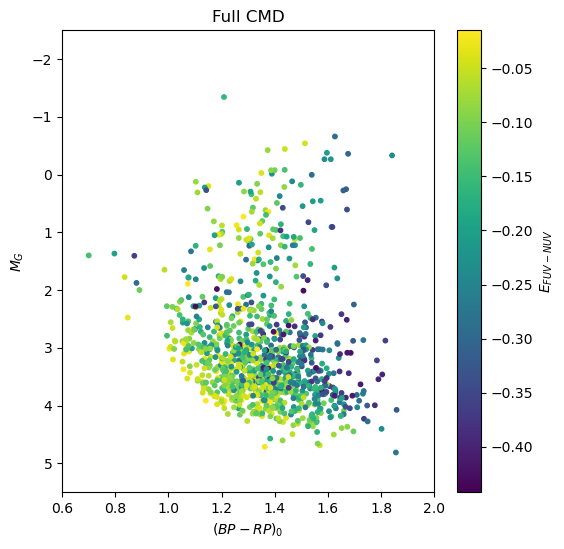

In [19]:
fig, ax = plt.subplots(1, figsize = (6,6))

ax.set_title('Full CMD')
im = ax.scatter(bp_rp, M_G, s = 10, c = E_FUV_NUV)#, vmin = 1, vmax = 5)
cb = fig.colorbar(im)
cb.set_label('$E_{FUV-NUV}$')
ax.set_xlim(0.60, 2)
ax.set_ylim(-2.5,5.5)
ax.invert_yaxis()
ax.set_xlabel('$(BP-RP)_0$')
ax.set_ylabel('$M_G$')


Text(0, 0.5, '$M_G$')

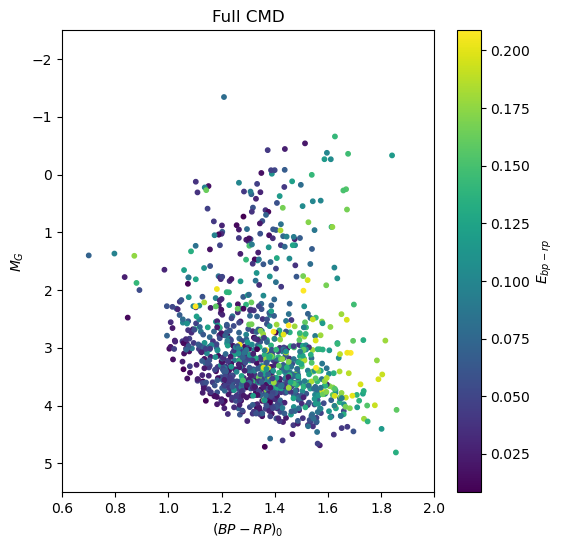

In [20]:
fig, ax = plt.subplots(1, figsize = (6,6))

ax.set_title('Full CMD')
im = ax.scatter(bp_rp, M_G, s = 10, c = Ebp_rp)#, vmin = 1, vmax = 5)
cb = fig.colorbar(im)
cb.set_label('$E_{bp-rp}$')
ax.set_xlim(0.60, 2)
ax.set_ylim(-2.5,5.5)
ax.invert_yaxis()
ax.set_xlabel('$(BP-RP)_0$')
ax.set_ylabel('$M_G$')

In [24]:
fitlim_05 = ((BP_RP05 >= 0.65) & (BP_RP05 <= 2.60)
            & (G_05 >= -2.5) & (G_05 <= 5.5))
fitlim_00 = ((BP_RP00 >= 0.65) & (BP_RP00 <= 2.60)
            & (G_00 >= -2.5) & (G_00 <= 5.5))
fitlim_low025 = ((BP_RP_low025 >= 0.65) & (BP_RP_low025 <= 2.60)
            & (G_low025 >= -2.5) & (G_low025 <= 5.5))

 #rcond==None, full==False, w==None, cov==False)4
MG_test = np.arange(0.65, 2.60, 0.01)

#Polyfiting
g_poly05 = np.polyfit(BP_RP05[fitlim_05][0:143], G_05[fitlim_05][0:143], 10)
p05 = np.poly1d(g_poly05)

g_poly00 = np.polyfit(BP_RP00[fitlim_00][0:177], G_00[fitlim_00][0:177], 10)
p00 = np.poly1d(g_poly00)

g_polylow025 = np.polyfit(BP_RP_low025[fitlim_low025][0:191], G_low025[fitlim_low025][0:191], 10)
p_low025 = np.poly1d(g_polylow025)


ssg_05 = (M_G > p05(bp_rp))
ssg_00 = (M_G > p00(bp_rp))
ssg_low025 = (M_G > p_low025(bp_rp))



In [68]:
ssgs = (((fe_h2b & ssg_00) == True) | ((fe_h1b & ssg_05) == True) | ((fe_h3b & ssg_low025) == True))

In [81]:
valid_feh = (metallicity >= -100)


class_list = []
for i in range(len(ssgs)):
    if (ssgs[i] == True):
        class_list.append('SSG')
    elif (valid_feh[i] == True):
        class_list.append('RS')
    else:
        class_list.append('-999')
class_list = np.array(class_list)



fe_h = np.array([item if item > -100 else int(-999) for item in metallicity])

print(fe_h)


[-9.99000000e+02 -9.99000000e+02 -4.77699995e-01 ... -1.30400002e-01
 -9.99000000e+02 -9.99000000e+02]


In [82]:
raw_leiner2022_class = np.genfromtxt(file, usecols=17, dtype=str)
leiner2022_class = np.array([raw_leiner2022_class[gaia_ids2.index(item)] for item in gaia_data['source_id']], 
              dtype = str)

original_ssg = (leiner2022_class == 'SSG')

galex_id = np.array(gaia_data['name'])
print(galex_id)

['GALEX J024236.2+071726' 'GALEX J025521.0+153923'
 'GALEX J032403.3+152821' ... 'GALEX J202842.2-094317'
 'GALEX J210416.7-073637' 'GALEX J204457.7-035836']


In [88]:
non_var_ids = np.array([1655646778064790528, 3137895792132452736, 
                    672877103038407040, 4527508855614868992, 
                    1494123125466322560, 1605979810614504704, 1489388868914750976, 
                    4597154602175212672])

no_var_rvs = np.array([True if item in non_var_ids else False for item in gaia_data['source_id']])

raw_star_name1 = np.genfromtxt(file, usecols=1, dtype = str)
raw_star_name2 = np.genfromtxt(file, usecols=2, dtype = str)


filt = excess#no_var_rvs#excess #no_var_rvs


exc_data = gaia_data[filt]

#excess_ssg = np.array([True if item in gaia_data['source_id'][excess] else False for item in exc_data['source_id']])

star_name1 = np.array([raw_star_name1[gaia_ids2.index(item)] for item in exc_data['source_id']], dtype = str)
star_name2 = np.array([raw_star_name2[gaia_ids2.index(item)] for item in exc_data['source_id']], dtype = str)
star_name = np.array([star_name1[k] + ' ' + star_name2[k] for k in range(len(star_name1))])

rv_data_points = np.zeros(len(exc_data), dtype = int)
rv_data_points[3] = int(2)
rv_data_points[11] = int(5)


final_dict = {'Gaia DR3 ID': exc_data['source_id'], 'Name': star_name, 'GALEX ID': galex_id[filt],'ra': np.round(exc_data['ra'],5), 
            'dec': np.round(exc_data['dec'],5),'dist': np.array(dist[filt], dtype = int), 'BP-RP0': bp_rp[filt],
              'FUV-NUV': fuv_nuv[filt], 'g_mag': m_G[filt], 'NUV_Mag': uncor_nuv[filt], 'FUV_Mag': uncor_fuv[filt], 
              'PVSX': periods[filt], '[M/H]': fe_h[filt],  'AV': av[filt], 'E(B-V)': E_BV[filt], 
              'class_Leiner2022': leiner2022_class[filt],'class_updated': class_list[filt],
              'RV_Observations': rv_data_points}


'''{'Gaia DR3 ID': np.array(exc_data['source_id']), 'Name': ssg_name[ssg_follow], 'ra': np.round(exc_data['ra'],5), 
            'dec': np.round(exc_data['dec'],5), 'FUV-NUV': fuv_nuv[excess], 'Excess': excess_ssg}'''
'''
            {'Gaia DR3 ID': np.array(exc_data['source_id']), 'Name': star_name, 'ra': np.round(exc_data['ra'],5), 
            'dec': np.round(exc_data['dec'],5), 'pmra': np.round(exc_data['pmra'],5), 
              'pmdec': np.round(exc_data['pmdec'],5),'dist': np.array(dist[excess], dtype = int),
              'g_mag': np.round(m_G[excess], 2)}
'''
final_df = pandas.DataFrame(final_dict)

print(final_df)
#final_df.to_csv('FILES\\uv_excess.csv', index=False)

            Gaia DR3 ID                     Name                GALEX ID  \
0    397690027169628672  ZTF J012055.17+450752.0  GALEX J012055.2+450751   
1    654503129867566080     CSS J075410.6+141829  GALEX J075410.6+141828   
2    755517221614519808                   AD LMi  GALEX J102622.6+374513   
3    871136882231721600                V0340 Gem  GALEX J072132.9+260932   
4    906058127442277248     CSS J081117.6+360733  GALEX J081117.5+360735   
5   1232279031219489792  ZTF J141527.19+164234.7  GALEX J141527.2+164234   
6   1303115931129472896  ZTF J161259.34+250041.0  GALEX J161259.3+250041   
7   1381075634865165568  ZTF J162639.53+412116.7  GALEX J162639.5+412117   
8   1382759605642657920  ZTF J155936.55+394851.3  GALEX J155936.6+394851   
9   1422377586571452032  ZTF J173010.13+572439.7  GALEX J173010.1+572437   
10  1642379516712248064          GSC 04196-02053  GALEX J162509.8+664539   
11  1655646778064790528                   DR Dra  GALEX J173240.9+741340   
12  17080053